In [1]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
print(tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE

import deepcell
# Changed from before due to new placement of Track, concat_tracks
from deepcell_tracking.utils import load_trks
from deepcell.data.tracking import Track, concat_tracks
##############
from sklearn.model_selection import train_test_split
from deepcell.utils.data_utils import reshape_movie
from deepcell.utils.transform_utils import erode_edges
from deepcell.data import split_dataset
from deepcell_toolbox.processing import normalize, histogram_normalization

import spektral

2.8.0


In [2]:
# data loading

path_temp_trks = '/data/3T3_nuc_s0-s2.trks'
all_data = [load_trks(path_temp_trks)]

In [3]:
%%time
all_tracks = [Track(tracked_data=d) for d in all_data]

 75%|█████████████████████████████████           | 9/12 [00:29<00:08,  2.90s/it]/usr/local/lib/python3.8/dist-packages/deepcell_tracking/utils.py:544: UserWarning: Lineage 57 has daughter 78 in a non-subsequent frame.
  warnings.warn('Lineage {} has daughter {} in a '
/usr/local/lib/python3.8/dist-packages/deepcell_tracking/utils.py:569: UserWarning: Cell 57 ends in frame 10 but daughter 78 first appears in frame 12.
  warnings.warn(
100%|███████████████████████████████████████████| 11/11 [00:48<00:00,  4.45s/it]
2022-06-28 04:38:51.836599: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-28 04:38:52.536792: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:

CPU times: user 1min 38s, sys: 7.29 s, total: 1min 46s
Wall time: 1min 33s


In [4]:
%%time
track_info = concat_tracks(all_tracks)

CPU times: user 154 ms, sys: 204 ms, total: 357 ms
Wall time: 355 ms


In [5]:
from skimage.exposure import rescale_intensity

def norm(X):
    X_norm = histogram_normalization(X, kernel_size=32)
    
    X_rescaled = np.zeros(X_norm.shape)
    for batch in range(X.shape[0]):
        for frame in range(X.shape[1]):
            x = X[batch, frame]
            x = rescale_intensity(x, out_range=(0,1))
            X_rescaled[batch, frame] = x
            
    return X_rescaled

In [6]:
for k, v in track_info.items():
    print(k, v.shape)

appearances (11, 71, 168, 32, 32, 1)
centroids (11, 71, 168, 2)
morphologies (11, 71, 168, 3)
adj_matrices (11, 71, 168, 168)
norm_adj_matrices (11, 71, 168, 168)
temporal_adj_matrices (11, 70, 168, 168, 3)


In [7]:
appearances = track_info['appearances']

app_shape = np.shape(appearances)
appearances = np.swapaxes(appearances, 1,2) #(0,2,1,3,4,5))
appearances = np.reshape(appearances, [-1, app_shape[1], app_shape[3], app_shape[4], app_shape[5]])

# Normalize appearances
appearances = norm(appearances)

input_dict = {'appearances': appearances}

output_dict = {'appearances_decoder': appearances}

data = tf.data.Dataset.from_tensor_slices((input_dict, output_dict))

data = data.repeat().batch(1)

In [8]:
it = iter(data)
nxt = it.next()
type(nxt)

tuple

In [9]:
print(len(nxt))
print(nxt[0].keys())
print(nxt[1].keys())
print(type(nxt[0]['appearances']))
print(nxt[0]['appearances'].get_shape())

2
dict_keys(['appearances'])
dict_keys(['appearances_decoder'])
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 71, 32, 32, 1)


In [10]:
def get_corr_img_in_tf_dataset(batch, frame, cell):
    it = iter(data)
    
    shape = track_info['appearances'].shape
    # number of batches * number of cells per batch
    cell_num = shape[2] * batch + cell + 1
    for cell in range(cell_num):
        nxt = it.next()
        
    return nxt[0]['appearances'][0][frame].numpy().astype('float32')

In [11]:
import matplotlib.pyplot as plt

def show_img_and_corr_img(batch, frame, cell):
    fig, ax = plt.subplots()
    ax.imshow(track_info['appearances'][batch][frame][cell])

    corr_img = get_corr_img_in_tf_dataset(batch, frame, cell)
    fig, ax = plt.subplots()
    ax.imshow(corr_img)

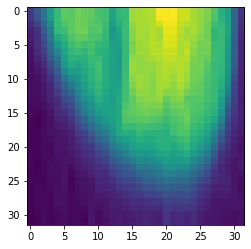

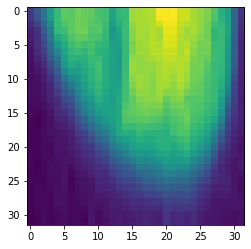

In [12]:
show_img_and_corr_img(0, 0, 0)

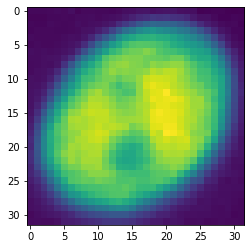

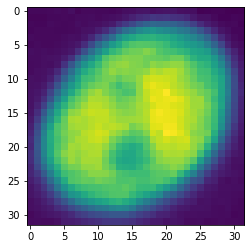

In [13]:
show_img_and_corr_img(0, 30, 5)

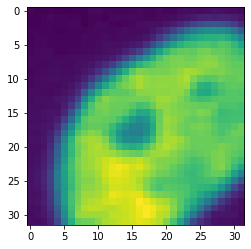

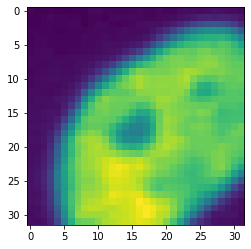

In [14]:
show_img_and_corr_img(4, 32, 50)

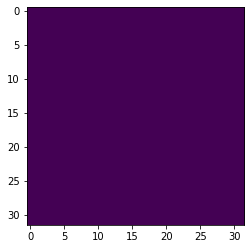

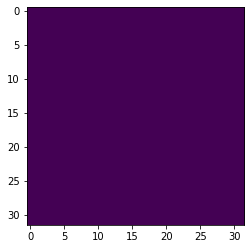

In [15]:
show_img_and_corr_img(4, 32, 160)

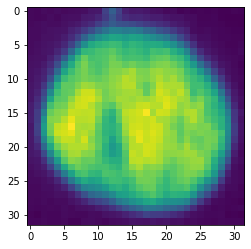

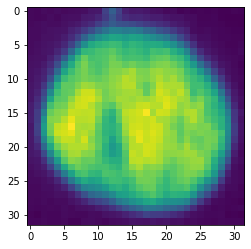

In [16]:
show_img_and_corr_img(10, 0, 50)

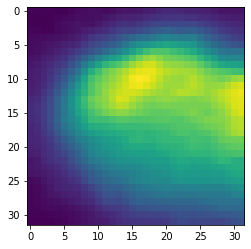

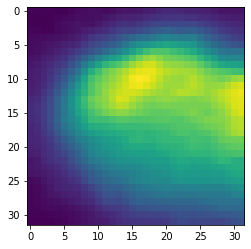

In [17]:
show_img_and_corr_img(10, 0, 60)

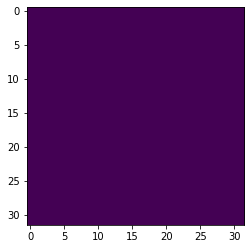

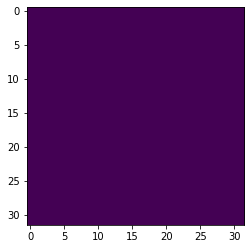

In [18]:
show_img_and_corr_img(10, 0, 70)